<a href="https://colab.research.google.com/github/shengjinbiao/DeepSeek-OCR/blob/main/DeepSeek_OCR_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepSeek-OCR on Google Colab

This notebook sets up and runs the DeepSeek-OCR model for optical character recognition.

**Requirements:**
- GPU Runtime (T4 or better recommended)
- ~15-20 minutes setup time

**Based on:** https://github.com/deepseek-ai/DeepSeek-OCR

## 1. Environment Setup and GPU Check

In [2]:
# Check GPU availability
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Mon Oct 27 11:24:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Clone Repository

In [3]:
# Clone the DeepSeek-OCR repository
!git clone https://github.com/deepseek-ai/DeepSeek-OCR.git
%cd DeepSeek-OCR

Cloning into 'DeepSeek-OCR'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 46 (delta 13), reused 2 (delta 2), pack-reused 21 (from 2)
Receiving objects: 100% (46/46), 7.78 MiB | 45.81 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/DeepSeek-OCR


## 3. Install Dependencies

Installing PyTorch, transformers, and other required packages.

In [4]:
# Install PyTorch with CUDA support (Colab typically has CUDA 11.8 or 12.1)
# Note: Colab may already have PyTorch installed, but we ensure compatible version
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [5]:
# Install requirements from the repository
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.6 MB/s eta 0:00:00
  Created wheel for img2pdf: filename=img2pdf-0.6.1-py3-none-any.whl size=51001 sha256=57f9f2e1c78d70421fb0ff4b135c8c01578c606f4fb8b3a7b861b3a561745af7
  Stored in directory: /root/.cache/pip/wheels/a5/05/56/c05447973db749cd2178b8f95e36f007f0af5f5dce2c6197a5
Successfully built img2pdf
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfull

In [1]:
# Install flash-attention (this may take 5-10 minutes to compile)
!pip install flash-attn==2.7.3 --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp312-cp312-linux_x86_64.whl size=414494788 sha256=567bddcae6f7c133fd964bed9988926fe7aabaddb58bf62a744b2f782a7d4269
  Stored in directory: /root/.cache/pip/wheels/f6/ba/3a/e5622e4a21e0735b65d5f7a0aca41c83467aaf2122031d214e
Successfully built flash-attn


## 4. Upload Test Image

Upload your Capture.PNG file here.

Please upload your Capture.PNG file:


Saving page_145.png to page_145.png

Uploaded file: page_145.png

Preview of uploaded image:


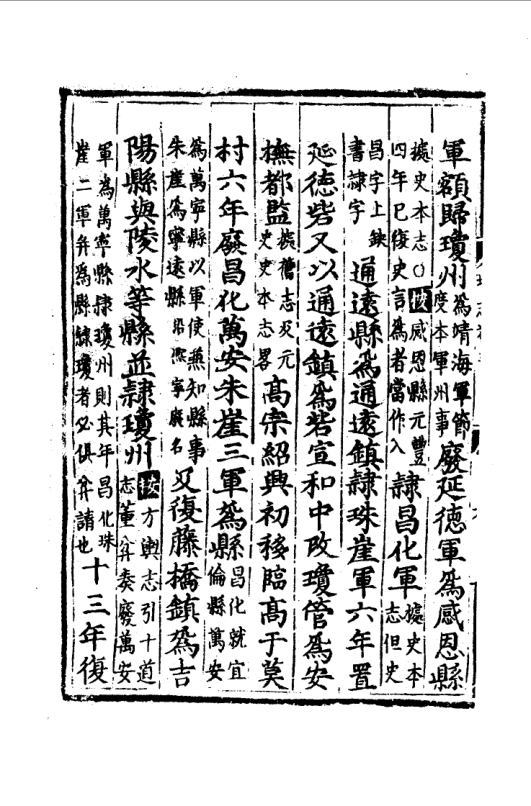

In [10]:
from google.colab import files
from IPython.display import Image, display
import os

# Upload the image
print("Please upload your Capture.PNG file:")
uploaded = files.upload()

# Get the uploaded filename
image_path = list(uploaded.keys())[0]
print(f"\nUploaded file: {image_path}")

# Display the uploaded image
print("\nPreview of uploaded image:")
display(Image(filename=image_path))

In [3]:
# Reinstall flash-attention with specific CUDA version
# Check your CUDA version with !nvidia-smi and adjust cu121 if necessary
!pip install flash-attn==2.7.3 --no-build-isolation --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


## 5. Load DeepSeek-OCR Model

This will download the model from HuggingFace (may take a few minutes).

In [4]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model...")
print("This may take several minutes on first run...\n")

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Removing attn_implementation='flash_attention_2' as a troubleshooting step
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Loading DeepSeek-OCR model...
This may take several minutes on first run...



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- configuration_deepseek_v2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekv2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


deepencoder.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- deepencoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- configuration_deepseek_v2.py
- modeling_deepseekv2.py
- deepencoder.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model device: cuda:0
Model dtype: torch.bfloat16


In [5]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model...")
print("This may take several minutes on first run...\n")

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Removing attn_implementation='flash_attention_2' as a troubleshooting step
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

Loading DeepSeek-OCR model...
This may take several minutes on first run...



You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model device: cuda:0
Model dtype: torch.bfloat16


## 6. Run OCR Inference

In [11]:
from PIL import Image
import time
import os
import torch

# Load the image (already loaded in a previous cell, but keeping this for clarity)
# img = Image.open(image_path)
# print(f"Image size: {img.size}")
# print(f"Image mode: {img.mode}\n")

# Set CUDA device (already set in model loading, but keeping for clarity)
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'

print("Running OCR inference using model.infer...\n")
start_time = time.time()

# Define prompt and output path
# prompt = "<image>\nFree OCR. "
prompt = "<image>\n<|grounding|>Convert the document to markdown. "
output_path = '/content/ocr_output' # Define an output directory

# Create output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Run inference using the infer method
with torch.no_grad():
    # infer(self, tokenizer, prompt='', image_file='', output_path = ' ', base_size = 1024, image_size = 640, crop_mode = True, test_compress = False, save_results = False):

    # Tiny: base_size = 512, image_size = 512, crop_mode = False
    # Small: base_size = 640, image_size = 640, crop_mode = False
    # Base: base_size = 1024, image_size = 1024, crop_mode = False
    # Large: base_size = 1280, image_size = 1280, crop_mode = False

    # Gundam: base_size = 1024, image_size = 640, crop_mode = True

    res = model.infer(tokenizer,
                      prompt=prompt,
                      image_file=image_path, # Use the uploaded image path
                      output_path=output_path,
                      base_size=1024,
                      image_size=640,
                      crop_mode=True,
                      save_results=True,
                      test_compress=True)

end_time = time.time()

print(f"Inference completed in {end_time - start_time:.2f} seconds\n")
print("=" * 80)
print("OCR RESULT:")
print("=" * 80)
# The infer method might return different formats,
# we will assume it returns the text directly or in a structure we can access.
# You might need to adjust this based on the actual output format of model.infer
print(res)
print("=" * 80)

# Note: The infer method with save_results=True should save the output to output_path
# You might need to adjust the saving and downloading logic in the next cell
# depending on how model.infer saves the results.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Running OCR inference using model.infer...

BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[800, 166, 895, 863]]<|/det|>
軍潁歸瓊州爲靖海軍節度延德軍爲威恩縣 

<|ref|>text<|/ref|><|det|>[[760, 166, 808, 230]]<|/det|>
歲史本志 

<|ref|>text<|/ref|><|det|>[[760, 228, 812, 863]]<|/det|>
國威恩縣元豐誌昌化軍 

<|ref|>text<|/ref|><|det|>[[667, 166, 770, 863]]<|/det|>
四年已後史言爲當作入志史
昌字上缺
書諫字
延德岑又以通遠鎮爲若宣和中改瓊管爲安 

<|ref|>text<|/ref|><|det|>[[575, 166, 675, 863]]<|/det|>
 

<|ref|>text<|/ref|><|det|>[[533, 166, 587, 430]]<|/det|>
 

<|ref|>text<|/ref|><|det|>[[533, 428, 587, 863]]<|/det|>
高宗紹興初移臨高于莫 

<|ref|>text<|/ref|><|det|>[[440, 166, 499, 863]]<|/det|>
 

<|ref|>text<|/ref|><|det|>[[398, 166, 455, 863]]<|/det|>
村六年廢昌化萬安朱崖三軍爲縣 

<|ref|>text<|/ref|><|det|>[[356, 166, 410, 430]]<|/det|>
爲萬字縣以軍使無知縣事 

<|ref|>text<|/ref|><|det|>[[356, 428, 410, 863]]<|/det|>
又復藤橋鎮爲吉 

<|ref|>text<|/ref|><|det|>[[314, 166, 368, 430]]<|/det|>
朱崖爲寧遠縣 

<|ref|>text<|/ref|><|det|>[[314, 428, 368, 86

image: 0it [00:00, ?it/s]
other: 100%|██████████| 24/24 [00:00<00:00, 175677.65it/s]

Inference completed in 27.15 seconds

OCR RESULT:
None


## 8. Batch Processing (Optional)

Process multiple images at once.

In [12]:
from PIL import Image
import time
import os
import torch

# Upload multiple images
print("Upload multiple images for batch processing:")
uploaded_files = files.upload()

results = {}
output_path = '/content/batch_ocr_output' # Define a directory for batch output

# Create output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

for filename in uploaded_files.keys():
    print(f"\nProcessing {filename}...")

    try:
        # Construct the full image path in the current working directory
        image_path = os.path.join(os.getcwd(), filename)

        # Define prompt (adjust based on DeepSeek-OCR's expected format)
        prompt = "<image>\n<|grounding|>Convert the document to markdown. "

        with torch.no_grad():
            # Use the infer method for batch processing
            res = model.infer(tokenizer,
                              prompt=prompt,
                              image_file=image_path, # Use the uploaded image path
                              output_path=output_path,
                              base_size=1024,
                              image_size=640,
                              crop_mode=True,
                              save_results=True,
                              test_compress=True)

            # The infer method with save_results=True saves the output to output_path
            # You might need to adjust how to retrieve or confirm the saved result
            # For this example, we'll just note that it was processed.
            results[filename] = f"Processed. Output saved to {output_path}"
            print(f"✓ {filename} processed successfully. Output saved to {output_path}")

    except Exception as e:
        print(f"✗ Error processing {filename}: {str(e)}")
        results[filename] = f"Error: {str(e)}"

# Display all results (or confirmation of processing)
print("\n" + "=" * 80)
print("BATCH PROCESSING SUMMARY")
print("=" * 80)

for filename, result in results.items():
    print(f"\n--- {filename} ---")
    print(result)
    print()

print(f"\nDetailed results are saved in the directory: {output_path}")

# Note: Downloading the batch results as a single file might require
# zipping the output directory or iterating through saved files.
# This part is commented out as model.infer handles saving.
# with open('batch_results.txt', 'w', encoding='utf-8') as f:
#     for filename, result in results.items():
#         f.write(f"{'='*80}\n")
#         f.write(f"File: {filename}\n")
#         f.write(f"{'='*80}\n")
#         f.write(result)
#         f.write(f"\n\n")
#
# files.download('batch_results.txt')

Upload multiple images for batch processing:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Saving page_11.png to page_11.png
Saving page_12.png to page_12 (1).png
Saving page_13.png to page_13.png

Processing page_11.png...
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[600, 130, 856, 860]]<|/det|>
守公亦嘗有是舉而未就遂協意
下示以目錄俾督合師儒多識者
博采猶故以增新各具實錄總三州十邑
咸卒焉公以預退休林下無塵事羈因簡 

<|ref|>text<|/ref|><|det|>[[410, 129, 610, 860]]<|/det|>
爲之脩輯乃於舊所集錄者折衷之去其
繫無考其疑闕補其新增輯其編次歷季
餘而始成快凡若干卷然後一郡之古今 

<|ref|>text<|/ref|><|det|>[[101, 125, 415, 860]]<|/det|>
事迹山水奇觀物產宦寓之屬繫然有條
可觀既而欲毀諸梓以垂不朽謂須宜叙
image size:  (542, 806)
valid image tokens:  772
output texts tokens (valid):  195
compression ratio:  0.25
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 3/3 [00:00<00:00, 36792.14it/s]

✓ page_11.png processed successfully. Output saved to /content/batch_ocr_output

Processing page_12 (1).png...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[670, 125, 920, 863]]<|/det|>
其端由此觀之則公之心行前此未有也
復何辭於歲生長一方而不知一方事恥
也若事有所不知而強以為知者非智也
余於是編非強也亦非沽釣也特領命于 

<|ref|>text<|/ref|><|det|>[[320, 128, 675, 868]]<|/det|>
公養其所知者爲之而已至其所未知而
外錯失缺者又俟君子恕其徃僭筆削增
損之何如爾成化十四年戊戌秋
image size:  (542, 806)
valid image tokens:  772
output texts tokens (valid):  138
compression ratio:  0.18
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 2/2 [00:00<00:00, 27147.60it/s]

✓ page_12 (1).png processed successfully. Output saved to /content/batch_ocr_output

Processing page_13.png...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[660, 120, 831, 550]]<|/det|>
東檄行祠會修志序
瓊州府海外一郡耳我 

<|ref|>text<|/ref|><|det|>[[572, 120, 666, 840]]<|/det|>
太祖高皇帝玉音用勞海南衛武臣則以
比之侯邦甸服而曰南溟浩瀚中有奇甸 

<|ref|>text<|/ref|><|det|>[[490, 120, 580, 840]]<|/det|>
數千里洪武開國勅音諭海南疆域臣 

<|ref|>text<|/ref|><|det|>[[400, 120, 494, 840]]<|/det|>
民則以比之鄒魯教化而曰海南習禮義 

<|ref|>text<|/ref|><|det|>[[209, 120, 410, 840]]<|/det|>
之敎有華夏之風歷觀嶺南州郡自入職方以來 

<|ref|>text<|/ref|><|det|>[[72, 120, 220, 630]]<|/det|>
皇極歎言未有如瓊州得蒙
image size:  (542, 806)
valid image tokens:  772
output texts tokens (valid):  220
compression ratio:  0.28
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 6/6 [00:00<00:00, 103563.06it/s]

✓ page_13.png processed successfully. Output saved to /content/batch_ocr_output

BATCH PROCESSING SUMMARY

--- page_11.png ---
Processed. Output saved to /content/batch_ocr_output


--- page_12 (1).png ---
Processed. Output saved to /content/batch_ocr_output


--- page_13.png ---
Processed. Output saved to /content/batch_ocr_output


Detailed results are saved in the directory: /content/batch_ocr_output


In [13]:
from PIL import Image
import time
import os
import torch

# Upload multiple images
print("Upload multiple images for batch processing:")
uploaded_files = files.upload()

results = {}
output_path = '/content/batch_ocr_output2' # Define a directory for batch output

# Create output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

for filename in uploaded_files.keys():
    print(f"\nProcessing {filename}...")

    try:
        # Construct the full image path in the current working directory
        image_path = os.path.join(os.getcwd(), filename)

        # Define prompt (adjust based on DeepSeek-OCR's expected format)
        prompt = "<image>\n<|grounding|>Convert the document to markdown. "

        with torch.no_grad():
            # Use the infer method for batch processing
            res = model.infer(tokenizer,
                              prompt=prompt,
                              image_file=image_path, # Use the uploaded image path
                              output_path=output_path,
                              base_size=1024,
                              image_size=640,
                              crop_mode=True,
                              save_results=True,
                              test_compress=True)

            # The infer method with save_results=True saves the output to output_path
            # You might need to adjust how to retrieve or confirm the saved result
            # For this example, we'll just note that it was processed.
            results[filename] = f"Processed. Output saved to {output_path}"
            print(f"✓ {filename} processed successfully. Output saved to {output_path}")

    except Exception as e:
        print(f"✗ Error processing {filename}: {str(e)}")
        results[filename] = f"Error: {str(e)}"

# Display all results (or confirmation of processing)
print("\n" + "=" * 80)
print("BATCH PROCESSING SUMMARY")
print("=" * 80)

for filename, result in results.items():
    print(f"\n--- {filename} ---")
    print(result)
    print()

print(f"\nDetailed results are saved in the directory: {output_path}")

# Note: Downloading the batch results as a single file might require
# zipping the output directory or iterating through saved files.
# This part is commented out as model.infer handles saving.
# with open('batch_results.txt', 'w', encoding='utf-8') as f:
#     for filename, result in results.items():
#         f.write(f"{'='*80}\n")
#         f.write(f"File: {filename}\n")
#         f.write(f"{'='*80}\n")
#         f.write(result)
#         f.write(f"\n\n")
#
# files.download('batch_results.txt')

Upload multiple images for batch processing:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Saving page_209.png to page_209.png
Saving page_210.png to page_210.png
Saving page_211.png to page_211.png
Saving page_212.png to page_212.png
Saving page_213.png to page_213.png
Saving page_214.png to page_214.png

Processing page_209.png...
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[140, 155, 920, 860]]<|/det|>
小於半說月俱與左二八分及內春夏秋冬短晝昼夜謂大
之半說月俱與左二八至九二月各夏秋冬短晝昼夜謂大
以雙星此俱無兩月二獨大九月內各甚長不短晝星夜
仰之乎每日此兩月潮潮水二獨大九月適此西流者若地形西沉北之高而東西矣盖因地形西流也東流而長北之高而東水
只而消電則南北無流耳矣十一月潮長最上則潮與信成爲
西南流下雷則以此始終然不無不同之偏論二潮自潮
者若月九六旬之或始終而東不終潮又長不謂之
以月流六月之始則旬之或始終而東不終潮又長不
謂文昌文昌錦囊潮對面長同海無之與候
無或云文昌所發明瓊海舊志候襄之余
無瓊海舊志候襄之餘
見如云間皆不能曲盡瓊海潮志候襄之
二如云間皆不能曲盡瓊海潮志候襄之餘
二見如云間皆不能曲盡瓊海潮志候襄之餘
二見二如云間皆不能曲盡瓊海潮志候襄之餘
二二見二如云間皆不能曲盡瓊海潮志候襄之餘
image size:  (531, 806)
valid image tokens:  768
output texts tokens (valid):  348
compression ratio:  0.45
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 1/1 [00:00<00:00, 12826.62it/s]

✓ page_209.png processed successfully. Output saved to /content/batch_ocr_output2

Processing page_210.png...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[66, 160, 840, 850]]<|/det|>
短星
長星
二大
十日
十日
十日
十日
十日
十日
十日
十日
十日
十日
長星
二八
長星
二六
十日
十日
十日
十日
十日
十日
十日
長星
二六
十日
十日
十日
十日
十日
十日
長星
二六
長星
二六
十日
十日
十日
十日
十日
十日
二六
長星
二六
十日
十日
十日
十日
十日
image size:  (531, 806)
valid image tokens:  768
output texts tokens (valid):  134
compression ratio:  0.17
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 1/1 [00:00<00:00, 15947.92it/s]

✓ page_210.png processed successfully. Output saved to /content/batch_ocr_output2

Processing page_211.png...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>sub_title<|/ref|><|det|>[[390, 137, 490, 430]]<|/det|>
瓊臺室志卷第四終 

<|ref|>text<|/ref|><|det|>[[730, 155, 920, 844]]<|/det|>
海溢俗呼海翻風起西北挾雨海水史謂高溢
濤積鹹連熟失耕
沿海區分畢苦之
image size:  (531, 806)
valid image tokens:  768
output texts tokens (valid):  80
compression ratio:  0.1
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 2/2 [00:00<00:00, 25040.62it/s]

✓ page_211.png processed successfully. Output saved to /content/batch_ocr_output2

Processing page_212.png...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>sub_title<|/ref|><|det|>[[749, 135, 835, 375]]<|/det|>
瓊臺志卷第五 

<|ref|>sub_title<|/ref|><|det|>[[580, 204, 650, 500]]<|/det|>
山川上嚴筒井泉附 

<|ref|>text<|/ref|><|det|>[[580, 499, 656, 576]]<|/det|>
自瓊山至樂會 

<|ref|>text<|/ref|><|det|>[[485, 245, 590, 860]]<|/det|>
山川非但表識疆域物產尤類頗秀昔人於吾郡指最
高之黎蠡為按印稍最長之南渡爲清河其餘若陶公 

<|ref|>text<|/ref|><|det|>[[400, 245, 496, 860]]<|/det|>
爲天下福地者源之遠通患泉以至一巖一井之微中
亦具有奇趣而不可略故皆依疆域列之以備考覽云 

<|ref|>sub_title<|/ref|><|det|>[[333, 135, 408, 247]]<|/det|>
瓊山 

<|ref|>text<|/ref|><|det|>[[333, 247, 400, 860]]<|/det|>
在縣南六十里白石都山下有 

<|ref|>text<|/ref|><|det|>[[300, 247, 345, 860]]<|/det|>
瓊山白石二村土石皆白如玉而潤種柳 

<|ref|>text<|/ref|><|det|>[[260, 247, 310, 860]]<|/det|>
味特美縣以此名 

<|ref|>text<|/ref|><|det|>[[220, 247, 270, 860]]<|/det|>
嶺第一山名駿四海內秀出萬峯間月下森瑤 

<|ref|>text<|/ref|><|det|>[[180, 247, 230, 860]]<|/det|>
嶺第一山一名駿四海內秀出萬峯間月下森瑤 

<|ref|>text<|/ref|>math<|/ref|><|det|>[[90, 167, 191, 860]]<|/det|>
簡風前振颯張

image: 0it [00:00, ?it/s]
other: 100%|██████████| 12/12 [00:00<00:00, 88612.06it/s]

✓ page_212.png processed successfully. Output saved to /content/batch_ocr_output2

Processing page_213.png...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[150, 156, 920, 856]]<|/det|>
屹立自何起其回草翔色翠房有於石
曲自何起其回草翔色翠房有於石
曲自何起其同草翔色翠房有於石
曲自何起其同草翔色翠
房有於石曲自何起其同草翔色
翠房有於石曲自何起其同草翔
色翠房有於石曲自何起其同草
翔色翠房有於石曲自何起其同
草翔色翠房有於石曲自何起其
同草翔色翠房有於石曲自何起
其同草翔色翠房有於石曲自何
起其同草翔色翠房有於石曲自
何起其同草翔色翠房有於石曲
自何起其同草翔色翠房有於石
曲自何起其自何起其自何起其自
何起其自何起其自何起其自何
起其自何起其自何起其自何
起其自何起其由何起其由何起
其由何起其由何起其由何起其
由何起其由何起其由何起其由
何起其由何起其由何起其由何
起其由何起其由何起其由何
起其由何起其自何起其自何
起其自何起其自何起其一何起
其一何起其一何起其一何起其一
何起其一何起其一何起其一何起
其一何起其一何起其一何起其一何
起其一何起其一何起其一何起其一何
起其一何起其一何起其自何起其一
何起其一何起其一何起其一何起其一
何起其一何起其一何起其自何起其一
何起其一何起其一自何起其一何起
其一何起其一何起其一何起其一何
起其自何起其一何起其一何起其一何
起其一何起其一何起其一自何起其一
何起其一何起其一何起其一何起其一何
起其一何起其一何何起其一何起其一何
起其一何起其一何起其一何何起其一何
起其一何起其一何何起其一何何起其一何
起其一何起其一何何起其一何起其一何
何起其一何起其一何何起其一何何起其一
何起其一何起其一何何起其一何何起其一
何起其一自何起其一何何起其一何何起
其一何起其一何何起其一何何起其一何
何起其一何何起其一何何起其一何何起
其一何起其一何何起其一自何起其一何
何起其一何何起其一何何起其一何何起一
何起其一何何起其一何何起其一何何起一
何起一何何起其一何何起其一何何起一
何起一何何起一何何起其一何何起一
何起一何何起一何何起一何何起一何何起
何起一何何起一何何起一何何起一何何起一
何起一何何起一何何起一何何起一一何何起
何起一何何起一何何起一何何起一一何何起一
何起一何

KeyboardInterrupt: 

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model for batch processing...")

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Removing attn_implementation='flash_attention_2' as a troubleshooting step
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully for batch processing!")

Loading DeepSeek-OCR model for batch processing...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully for batch processing!


## Troubleshooting

### Common Issues:

1. **Out of Memory (OOM):**
   - Use a higher-tier GPU (A100, V100)
   - Reduce image resolution before processing
   - Enable gradient checkpointing

2. **Flash Attention Installation Fails:**
   - Try removing `attn_implementation='flash_attention_2'` parameter
   - Fallback to standard attention mechanism

3. **Model Download Slow:**
   - This is normal for large models (may take 10-15 minutes)
   - Model is cached after first download

4. **Image Format Issues:**
   - Ensure image is in RGB format
   - Convert: `img = img.convert('RGB')`

### Performance Tips:

- Use images close to native resolutions: 512×512, 640×640, 1024×1024, 1280×1280
- For faster inference, use `torch.float16` (already enabled)
- Batch processing is more efficient for multiple images

## Cleanup (Optional)

Free up GPU memory when done.

In [ ]:
# Clear GPU memory
import gc

del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()

print("GPU memory cleared")

GPU memory cleared
